In [5]:
import pandas as pd
import os

df = pd.read_csv('../data/03_casos/df_con_variables_sub_reg_nt_50-all.csv')
df


,departamento,provincia,distrito,ano,semana,sub_reg_nt,ubigeo,ira_no_neumonia,neumonias_men5,neumonias_60mas,...,lag_3_semanas_defunciones_men5,lag_4_semanas_defunciones_men5,lag_5_semanas_defunciones_men5,lag_6_semanas_defunciones_men5,lag_1_semanas_defunciones_60mas,lag_2_semanas_defunciones_60mas,lag_3_semanas_defunciones_60mas,lag_4_semanas_defunciones_60mas,lag_5_semanas_defunciones_60mas,lag_6_semanas_defunciones_60mas
0,LIMA,YAUYOS,ALLAUCA,2021,47,50,151003,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LIMA,YAUYOS,ALLAUCA,2021,52,50,151003,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LIMA,YAUYOS,ALLAUCA,2022,43,50,151003,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,LIMA,YAUYOS,ALLAUCA,2022,44,50,151003,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,LIMA,YAUYOS,ALLAUCA,2023,14,50,151003,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54294,LIMA,YAUYOS,YAUYOS,2022,37,50,151001,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54295,LIMA,YAUYOS,YAUYOS,2023,10,50,151001,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54296,LIMA,CA�ETE,ZU�IGA,2005,24,50,150516,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54297,LIMA,CA�ETE,ZU�IGA,2006,44,50,150516,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor


# Target
y = df["hospitalizados_men5"]

# Features (drop target + identifiers that leak info)
X = df.drop(columns=["hospitalizados_men5", "ubigeo"])

# Define categorical and numeric features
categorical = ["departamento", "provincia", "distrito", "mes",
               "tiempo_mes", "tiempo_mes_anterior", "tiempo_estacion"]
numeric = [col for col in X.columns if col not in categorical]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric)
    ]
)

# Model
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])

# Train/Test split by time
train = df[df["ano"] < 2017]
test = df[(df["ano"] >= 2017) & (df["ano"] < 2021)]


X_train, y_train = train.drop(columns=["hospitalizados_men5", "ubigeo"]), train["hospitalizados_men5"]
X_test, y_test = test.drop(columns=["hospitalizados_men5", "ubigeo"]), test["hospitalizados_men5"]

# Fit
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)


In [7]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)


RMSE: 0.7943708679908117
MAE: 0.3631443679332733
R2: 0.7885453701019287


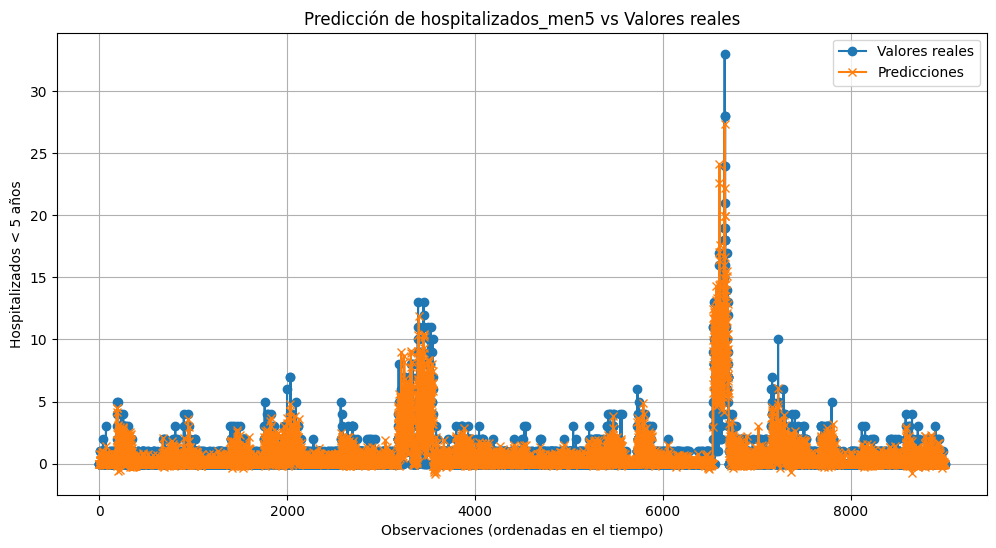

In [8]:
import matplotlib.pyplot as plt

# Asegúrate que y_test y y_pred tengan el mismo índice
y_test = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred, name="Predicciones")

plt.figure(figsize=(12, 6))

# Valores reales
plt.plot(y_test, label="Valores reales", marker="o")

# Predicciones
plt.plot(y_pred, label="Predicciones", marker="x")

plt.title("Predicción de hospitalizados_men5 vs Valores reales")
plt.xlabel("Observaciones (ordenadas en el tiempo)")
plt.ylabel("Hospitalizados < 5 años")
plt.legend()
plt.grid(True)
plt.show()


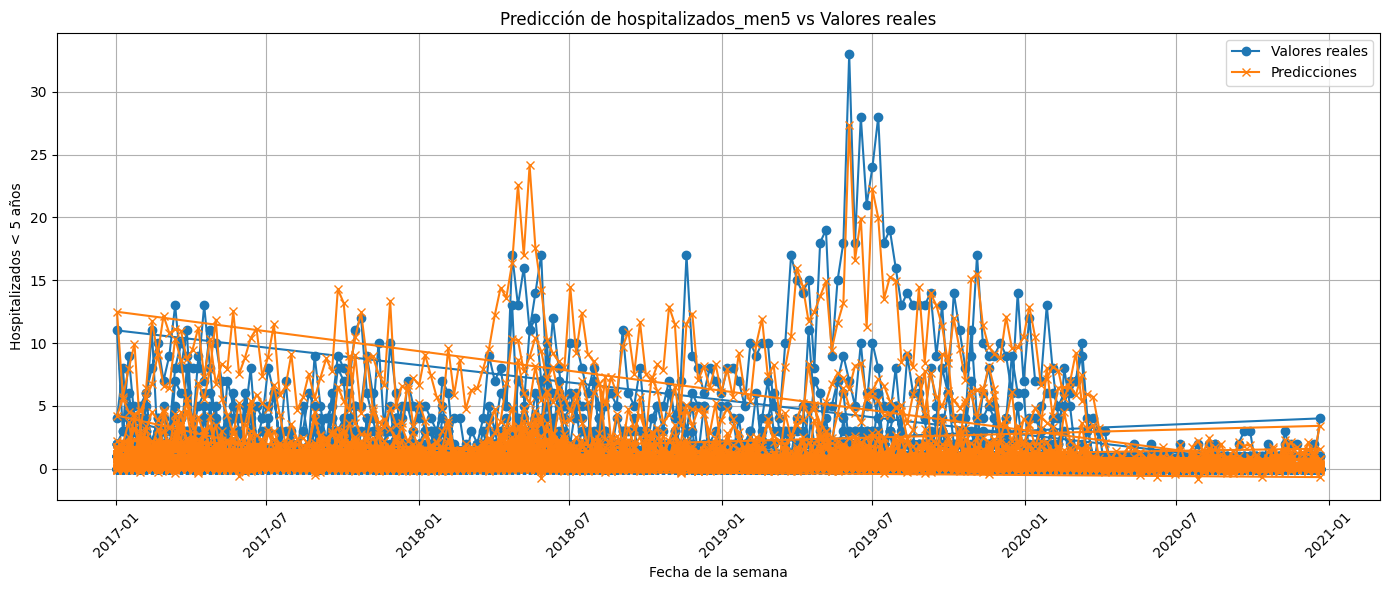

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear la columna de fechas ANTES del split
df["fecha_semana"] = pd.to_datetime(
    df["ano"].astype(str) + df["semana"].astype(str) + "1", 
    format="%G%V%u"
)

# Train/Test split por fecha
train = df[df["ano"] < 2017]
test = df[(df["ano"] >= 2017) & (df["ano"] < 2021)]

# Extraer las fechas del test
fechas_test = test["fecha_semana"].reset_index(drop=True)

# Asegurar índices consistentes
y_test = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred, name="Predicciones")

# Gráfico por fecha
plt.figure(figsize=(14, 6))
plt.plot(fechas_test, y_test, label="Valores reales", marker="o")
plt.plot(fechas_test, y_pred, label="Predicciones", marker="x")

plt.title("Predicción de hospitalizados_men5 vs Valores reales")
plt.xlabel("Fecha de la semana")
plt.ylabel("Hospitalizados < 5 años")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


                                     feature  importance
183                      num__neumonias_men5    0.212161
194       num__lag_3_semanas_ira_no_neumonia    0.088879
193       num__lag_2_semanas_ira_no_neumonia    0.041692
198        num__lag_1_semanas_neumonias_men5    0.030590
210   num__lag_1_semanas_hospitalizados_men5    0.030085
104     cat__distrito_SAN JUAN DE LURIGANCHO    0.024480
185                num__hospitalizados_60mas    0.018871
229     num__lag_2_semanas_defunciones_60mas    0.013621
221  num__lag_6_semanas_hospitalizados_60mas    0.013568
187                   num__defunciones_60mas    0.012397
220  num__lag_5_semanas_hospitalizados_60mas    0.012277
228     num__lag_1_semanas_defunciones_60mas    0.012208
219  num__lag_4_semanas_hospitalizados_60mas    0.011423
208       num__lag_5_semanas_neumonias_60mas    0.010902
152                   cat__tiempo_mes_Agosto    0.010496


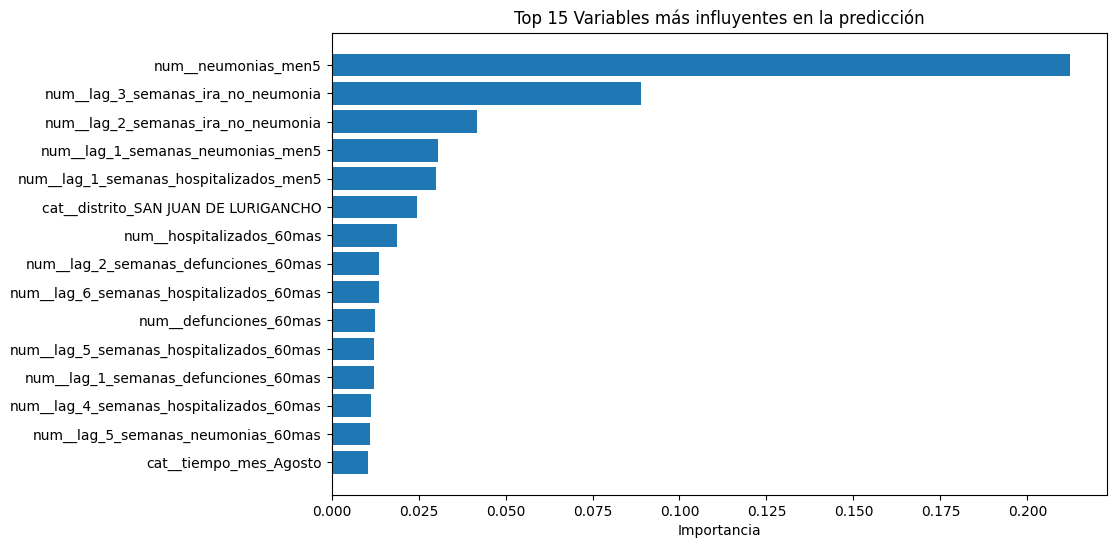

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer el modelo entrenado de la pipeline
xgb_model = pipeline.named_steps["model"]

# Obtener los nombres de las features después del preprocesamiento
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

# Importancias de XGBoost
importances = xgb_model.feature_importances_

# Crear dataframe con las importancias
feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Ver las 15 más importantes
print(feat_imp.head(15))

# Gráfico de las más influyentes
plt.figure(figsize=(10,6))
plt.barh(feat_imp.head(15)["feature"], feat_imp.head(15)["importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Variables más influyentes en la predicción")
plt.xlabel("Importancia")
plt.show()


In [3]:
import pandas as pd
import os

df = pd.read_csv('../data/03_casos/df_con_variables_sub_reg_nt_50-all.csv')
df


,departamento,provincia,distrito,ano,semana,sub_reg_nt,ubigeo,ira_no_neumonia,neumonias_men5,neumonias_60mas,...,lag_3_semanas_defunciones_men5,lag_4_semanas_defunciones_men5,lag_5_semanas_defunciones_men5,lag_6_semanas_defunciones_men5,lag_1_semanas_defunciones_60mas,lag_2_semanas_defunciones_60mas,lag_3_semanas_defunciones_60mas,lag_4_semanas_defunciones_60mas,lag_5_semanas_defunciones_60mas,lag_6_semanas_defunciones_60mas
0,LIMA,YAUYOS,ALLAUCA,2021,47,50,151003,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LIMA,YAUYOS,ALLAUCA,2021,52,50,151003,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LIMA,YAUYOS,ALLAUCA,2022,43,50,151003,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,LIMA,YAUYOS,ALLAUCA,2022,44,50,151003,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,LIMA,YAUYOS,ALLAUCA,2023,14,50,151003,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54294,LIMA,YAUYOS,YAUYOS,2022,37,50,151001,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54295,LIMA,YAUYOS,YAUYOS,2023,10,50,151001,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54296,LIMA,CA�ETE,ZU�IGA,2005,24,50,150516,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54297,LIMA,CA�ETE,ZU�IGA,2006,44,50,150516,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Training set shape: (38407, 234)
Test set shape: (9002, 234)
Number of features after preprocessing: 234

Model Architecture:


c:\Users\quine\Documents\repos_github\Samsung_innovation_campus_proyecto\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       120,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 298,753 (1.14 MB)

 Trainable params: 296,833 (1.13 MB)

 Non-trainable params: 1,920 (7.50 KB)


Training the Deep Neural Network...
Epoch 1/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.6849 - mae: 0.7627 - mse: 1.6849 - val_loss: 0.9859 - val_mae: 0.5269 - val_mse: 0.9859 - learning_rate: 0.0010
Epoch 2/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.2656 - mae: 0.6200 - mse: 1.2656 - val_loss: 1.1646 - val_mae: 0.5077 - val_mse: 1.1646 - learning_rate: 0.0010
Epoch 3/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0907 - mae: 0.5689 - mse: 1.0907 - val_loss: 0.8135 - val_mae: 0.4863 - val_mse: 0.8135 - learning_rate: 0.0010
Epoch 4/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9935 - mae: 0.5526 - mse: 0.9935 - val_loss: 0.8431 - val_mae: 0.4815 - val_mse: 0.8431 - learning_rate: 0.0010
Epoch 5/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0032 - mae: 0.5461 - mse: 1.0032 - val_loss: 0.7865 - val_mae: 0.4910 - val_mse: 0.7865 - learning_rate: 0.0010
Epoch 6/100
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9975 - mae: 0.5442 - mse:

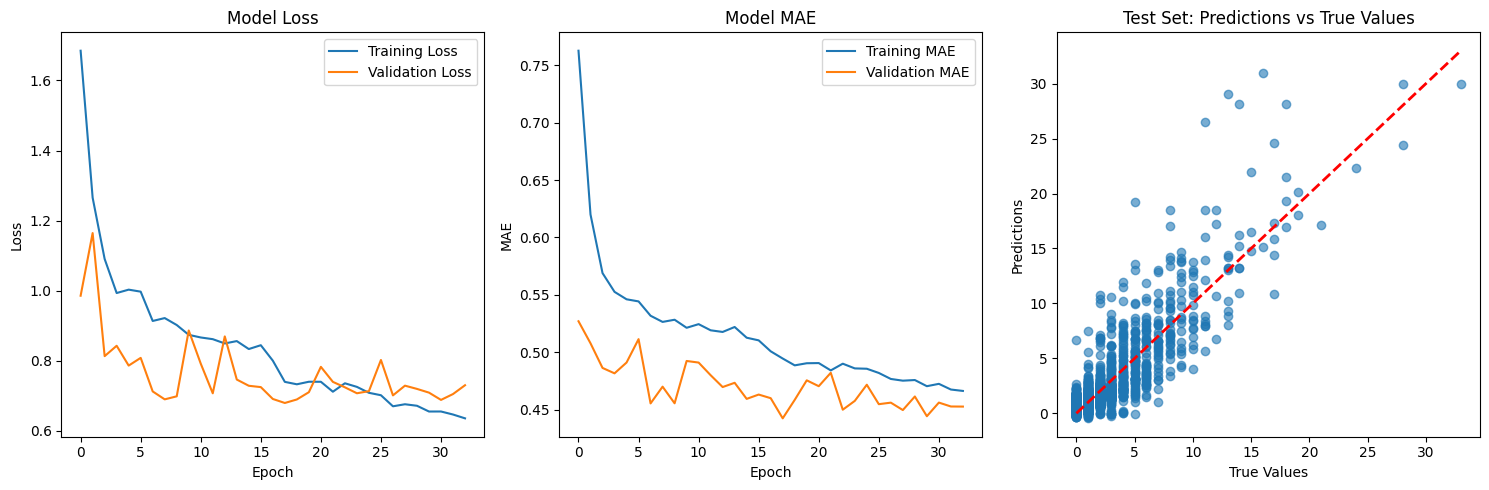


DEEP NEURAL NETWORK PERFORMANCE SUMMARY
              Training    Validation          Test
MAE       4.323000e-01  4.423000e-01  3.639000e-01
RMSE      8.094000e-01  8.245000e-01  8.701000e-01
R²        8.110000e-01  7.958000e-01  7.463000e-01
MAPE (%)  1.105627e+09  1.148888e+09  1.059571e+09

Note: For feature importance in neural networks, consider using:
- Permutation importance
- SHAP values
- Layer-wise relevance propagation

This is more complex than tree-based models due to the distributed nature of neural network representations.

Model training completed. Best validation loss: 0.6798
Total epochs trained: 33


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded
# Target
y = df["hospitalizados_men5"]

# Features (drop target + identifiers that leak info)
X = df.drop(columns=["hospitalizados_men5", "ubigeo"])

# Define categorical and numeric features
categorical = ["departamento", "provincia", "distrito", "mes",
               "tiempo_mes", "tiempo_mes_anterior", "tiempo_estacion"]
numeric = [col for col in X.columns if col not in categorical]

# Preprocessor - Important: Use StandardScaler for neural networks
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical),
        ("num", StandardScaler(), numeric)  # Standardization is crucial for neural networks
    ]
)

# Train/Test split by time (same as original)
train = df[df["ano"] < 2017]
test = df[(df["ano"] >= 2017) & (df["ano"] < 2021)]

X_train, y_train = train.drop(columns=["hospitalizados_men5", "ubigeo"]), train["hospitalizados_men5"]
X_test, y_test = test.drop(columns=["hospitalizados_men5", "ubigeo"]), test["hospitalizados_men5"]

# Fit preprocessor and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert to numpy arrays if needed
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"Training set shape: {X_train_processed.shape}")
print(f"Test set shape: {X_test_processed.shape}")
print(f"Number of features after preprocessing: {X_train_processed.shape[1]}")

# Split training data for validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42
)

# Build Deep Neural Network
def create_dnn_model(input_dim):
    model = keras.Sequential([
        # Input layer
        layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden layers
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        
        # Output layer
        layers.Dense(1, activation='linear')  # Linear for regression
    ])
    
    return model

# Create model
model = create_dnn_model(X_train_processed.shape[1])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

# Print model summary
print("\nModel Architecture:")
model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-6
)

# Train the model
print("\nTraining the Deep Neural Network...")
history = model.fit(
    X_train_final, y_train_final,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Make predictions
print("\nMaking predictions...")
y_pred_train = model.predict(X_train_processed).flatten()
y_pred_test = model.predict(X_test_processed).flatten()
y_pred_val = model.predict(X_val).flatten()

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Adding small epsilon to avoid division by zero
    
    print(f"\n{dataset_name} Metrics:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2, "MAPE": mape}

# Calculate and print metrics
train_metrics = calculate_metrics(y_train, y_pred_train, "Training Set")
val_metrics = calculate_metrics(y_val, y_pred_val, "Validation Set")
test_metrics = calculate_metrics(y_test, y_pred_test, "Test Set")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Test Set: Predictions vs True Values')
plt.tight_layout()
plt.show()

# Create a summary comparison
print("\n" + "="*60)
print("DEEP NEURAL NETWORK PERFORMANCE SUMMARY")
print("="*60)

metrics_summary = pd.DataFrame({
    'Training': [train_metrics['MAE'], train_metrics['RMSE'], train_metrics['R²'], train_metrics['MAPE']],
    'Validation': [val_metrics['MAE'], val_metrics['RMSE'], val_metrics['R²'], val_metrics['MAPE']],
    'Test': [test_metrics['MAE'], test_metrics['RMSE'], test_metrics['R²'], test_metrics['MAPE']]
}, index=['MAE', 'RMSE', 'R²', 'MAPE (%)'])

print(metrics_summary.round(4))

# Feature importance approximation using permutation importance (optional)
print("\nNote: For feature importance in neural networks, consider using:")
print("- Permutation importance")
print("- SHAP values") 
print("- Layer-wise relevance propagation")
print("\nThis is more complex than tree-based models due to the distributed nature of neural network representations.")

# Save model if needed
# model.save('hospitalization_dnn_model.h5')
print(f"\nModel training completed. Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"Total epochs trained: {len(history.history['loss'])}")